In [2]:
!pip install selenium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 476.0/476.0 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.7 MB/s eta 0:00:00


**Q1)Data Preparation**

In [5]:
!pip install webdriver-manager

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
import time
import pandas as pd

In [ ]:
def scroll_to_load_comments(driver):
    last_height = driver.execute_script("return document.documentElement.scrollHeight")

    while True:
        # Scroll down to the bottom of the page
        driver.execute_script("window.scrollTo(0, document.documentElement.scrollHeight);")

        # Wait for comments to load
        time.sleep(3)

        # Calculate new scroll height and compare with the last scroll height
        new_height = driver.execute_script("return document.documentElement.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

# Function to scrape comments
def scrape_youtube_comments(video_url):
    # Automatically install and use the appropriate ChromeDriver
    driver = webdriver.Chrome(ChromeDriverManager().install())
    driver.get(video_url)
    time.sleep(5)  # Wait for the page to load

    # Scroll down to load comments
    scroll_to_load_comments(driver)

    # Extract comments
    comments_section = driver.find_element(By.CSS_SELECTOR, '#contents #contents #contents')
    comment_elements = comments_section.find_elements(By.CSS_SELECTOR, '#content #content-text')

    comments = [comment.text.strip() for comment in comment_elements]

    driver.quit()  # Close the WebDriver
    return comments

# Function to save comments to CSV
def save_comments_to_csv(comments, filename):
    df = pd.DataFrame(comments, columns=["Comment"])
    df.to_csv(filename, index=False)

In [ ]:
video_url = "https://youtu.be/QVKj3LADCnA?si=t0XprixE7NMVV461"
comments = scrape_youtube_comments(video_url)
save_comments_to_csv(comments, "Comments_youtube.csv")

In [137]:
df = pd.read_csv("content/Comments_youtube.csv")

In [138]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

(695, 1)

In [140]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [141]:
stop_words = set(stopwords.words('english'))
negative_words = ['not', 'no', 'never', 'nor', 'neither']
new_stop_words = [word for word in stop_words if word not in negative_words]
def preprocess_text(text):
    if isinstance(text, (int, float)):
        return text
    text = str(text)
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in new_stop_words]
    return " ".join(tokens)

In [142]:
df['preprocessed_comment'] = df['Comment'].apply(preprocess_text)
df = df[df['preprocessed_comment'].str.strip().astype(bool)]

In [143]:
df

,Comment,preprocessed_comment
0,00:00 Lecture overview\n02:40 Elimination Succ...,lecture overview elimination success eliminati...
1,"I like this professor so much, listening his c...",like professor much listening course amusement
2,there's something about his lectures that make...,something lectures make easy concentrate follo...
3,This guy is amazing...When teachers taught thi...,guy amazing teachers taught college everything...
4,This kind of lecture is only possible when you...,kind lecture possible deep passion work huge t...
...,...,...
690,Goat !!!,goat
691,As a teacher myself I am always shocked to see...,teacher always shocked see lack participation ...
692,you are not a clear teacher because you not cl...,not clear teacher not clear step
693,I hate math.,hate math


In [144]:
df.dropna(inplace=True)

<ipython-input-144-c64f9f573c18>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


**Q2) Sentiment Classification**

In [58]:
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [59]:
sia = SentimentIntensityAnalyzer()

In [145]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import re

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Basic Sentiment Classification using VADER
def basic_sentiment_classification(text):
    score = sia.polarity_scores(text)

    if score['compound'] >= 0.05:
        return 'Positive'
    elif score['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Fine-Grained Sentiment Classification
def fine_grained_sentiment_classification(text):
    score = sia.polarity_scores(text)

    # Detecting questions or inquiry
    if is_question(text):
        return 'Question/Inquiry'

    if score['compound'] >= 0.75:
        return 'Strong Positive'
    elif 0.05 < score['compound'] < 0.75:
        return 'General Positive'
    elif -0.75 < score['compound'] <= -0.05:
        return 'General Negative'
    elif score['compound'] <= -0.75:
        return 'Strong Negative'
    else:
        return 'Neutral'


def is_question(text):

    return bool(re.search(r'\?|\b(who|what|when|where|why|how|which|can|could|would|should)\b', text.lower()))


df['Basic Sentiment'] = df['preprocessed_comment'].apply(basic_sentiment_classification)
df['Fine-Grained Sentiment'] = df['preprocessed_comment'].apply(fine_grained_sentiment_classification)
df['is_question/'] = df['preprocessed_comment'].apply(is_question)
# Display the updated DataFrame
print(df)

# Optionally, save to a CSV file
df.to_csv('classified_comments.csv', index=False)

                                               Comment  \
0    00:00 Lecture overview\n02:40 Elimination Succ...   
1    I like this professor so much, listening his c...   
2    there's something about his lectures that make...   
3    This guy is amazing...When teachers taught thi...   
4    This kind of lecture is only possible when you...   
..                                                 ...   
690                                          Goat !!!    
691  As a teacher myself I am always shocked to see...   
692  you are not a clear teacher because you not cl...   
693                                       I hate math.   
694   Not clear, lengthy, anticipate too much concepts   

                                  preprocessed_comment Basic Sentiment  \
0    lecture overview elimination success eliminati...        Positive   
1       like professor much listening course amusement        Positive   
2    something lectures make easy concentrate follo...        Positive   
3    gu

<ipython-input-145-252377ac8159>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Basic Sentiment'] = df['preprocessed_comment'].apply(basic_sentiment_classification)
<ipython-input-145-252377ac8159>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Fine-Grained Sentiment'] = df['preprocessed_comment'].apply(fine_grained_sentiment_classification)
<ipython-input-145-252377ac8159>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [146]:
df

,Comment,preprocessed_comment,Basic Sentiment,Fine-Grained Sentiment,is_question/
0,00:00 Lecture overview\n02:40 Elimination Succ...,lecture overview elimination success eliminati...,Positive,General Positive,False
1,"I like this professor so much, listening his c...",like professor much listening course amusement,Positive,General Positive,False
2,there's something about his lectures that make...,something lectures make easy concentrate follo...,Positive,Strong Positive,False
3,This guy is amazing...When teachers taught thi...,guy amazing teachers taught college everything...,Positive,General Positive,False
4,This kind of lecture is only possible when you...,kind lecture possible deep passion work huge t...,Positive,Strong Positive,False
...,...,...,...,...,...
690,Goat !!!,goat,Neutral,Neutral,False
691,As a teacher myself I am always shocked to see...,teacher always shocked see lack participation ...,Negative,Strong Negative,False
692,you are not a clear teacher because you not cl...,not clear teacher not clear step,Negative,General Negative,False
693,I hate math.,hate math,Negative,General Negative,False


Q3)Additional Sentiment Classification

In [148]:

from transformers import pipeline


In [149]:
# Initialize sarcasm classifier
sarcasm_classifier = pipeline("text-classification", model="helinivan/english-sarcasm-detector")

# Function to analyze emotional vs. objective and subjective vs. objective
def analyze_sentiment(row):
    text = row['preprocessed_comment']

    # Sarcasm Detection
    sarcasm_prediction = sarcasm_classifier(text)[0]
    is_sarcastic = sarcasm_prediction['label'] == 'sarcastic'

    # Emotional vs. Objective
    sentiment_score = TextBlob(text).sentiment
    emotional = 'emotional' if abs(sentiment_score.polarity) > 0.5 else 'objective'

    # Subjective vs. Objective
    subjectivity = 'subjective' if sentiment_score.subjectivity > 0.5 else 'objective'

    return pd.Series({
        'is_sarcastic': is_sarcastic,
        'emotional_objective': emotional,
        'subjective_objective': subjectivity
    })
    df[['is_sarcastic', 'emotional_objective', 'subjective_objective']] = df.apply(analyze_sentiment, axis=1)

# Display the results
print(df)

                                               Comment  \
0    00:00 Lecture overview\n02:40 Elimination Succ...   
1    I like this professor so much, listening his c...   
2    there's something about his lectures that make...   
3    This guy is amazing...When teachers taught thi...   
4    This kind of lecture is only possible when you...   
..                                                 ...   
690                                          Goat !!!    
691  As a teacher myself I am always shocked to see...   
692  you are not a clear teacher because you not cl...   
693                                       I hate math.   
694   Not clear, lengthy, anticipate too much concepts   

                                  preprocessed_comment Basic Sentiment  \
0    lecture overview elimination success eliminati...        Positive   
1       like professor much listening course amusement        Positive   
2    something lectures make easy concentrate follo...        Positive   
3    gu

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [150]:
df

,Comment,preprocessed_comment,Basic Sentiment,Fine-Grained Sentiment,is_question/
0,00:00 Lecture overview\n02:40 Elimination Succ...,lecture overview elimination success eliminati...,Positive,General Positive,False
1,"I like this professor so much, listening his c...",like professor much listening course amusement,Positive,General Positive,False
2,there's something about his lectures that make...,something lectures make easy concentrate follo...,Positive,Strong Positive,False
3,This guy is amazing...When teachers taught thi...,guy amazing teachers taught college everything...,Positive,General Positive,False
4,This kind of lecture is only possible when you...,kind lecture possible deep passion work huge t...,Positive,Strong Positive,False
...,...,...,...,...,...
690,Goat !!!,goat,Neutral,Neutral,False
691,As a teacher myself I am always shocked to see...,teacher always shocked see lack participation ...,Negative,Strong Negative,False
692,you are not a clear teacher because you not cl...,not clear teacher not clear step,Negative,General Negative,False
693,I hate math.,hate math,Negative,General Negative,False


**Q4) Sentiment Analysis Metrices**

Percentage of Positive Comments: 55.29%
Percentage of Negative Comments: 15.00%
Percentage of Neutral Comments: 29.71%
Percentage of Strong Positive Comments: 12.21%
Percentage of General Positive Comments: 38.09%
Percentage of General Negative Comments: 13.38%
Percentage of Strong Negative Comments: 0.74%
Percentage of Questions/Inquiries: 6.76%


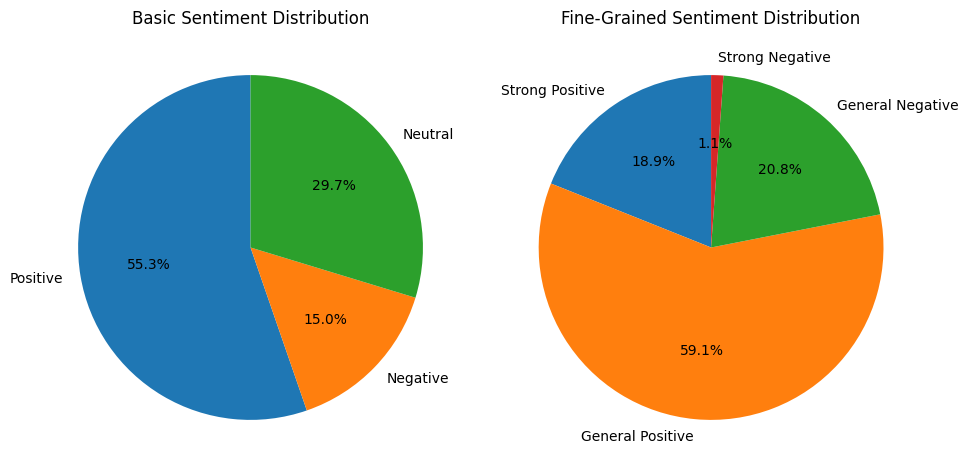

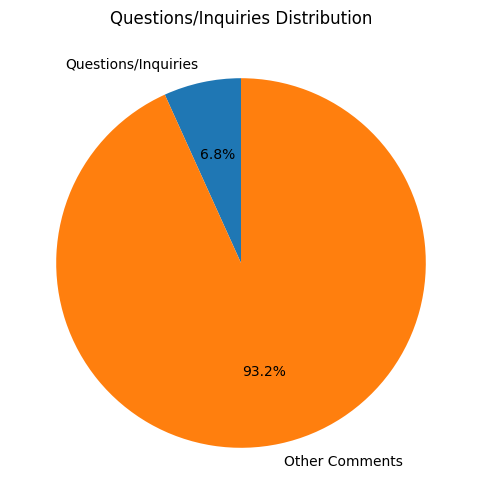

In [151]:
def sentiment_statistics(df):
    # Basic sentiment percentages
    total_comments = len(df)
    positive_count = df['Basic Sentiment'].value_counts().get('Positive', 0)
    negative_count = df['Basic Sentiment'].value_counts().get('Negative', 0)
    neutral_count = df['Basic Sentiment'].value_counts().get('Neutral', 0)

    positive_percentage = (positive_count / total_comments) * 100
    negative_percentage = (negative_count / total_comments) * 100
    neutral_percentage = (neutral_count / total_comments) * 100

    # Fine-grained sentiment percentages
    strong_positive_count = df['Fine-Grained Sentiment'].value_counts().get('Strong Positive', 0)
    general_positive_count = df['Fine-Grained Sentiment'].value_counts().get('General Positive', 0)
    general_negative_count = df['Fine-Grained Sentiment'].value_counts().get('General Negative', 0)
    strong_negative_count = df['Fine-Grained Sentiment'].value_counts().get('Strong Negative', 0)
    question_inquiry_count = df['Fine-Grained Sentiment'].value_counts().get('Question/Inquiry', 0)

    # Print the statistics
    print(f"Percentage of Positive Comments: {positive_percentage:.2f}%")
    print(f"Percentage of Negative Comments: {negative_percentage:.2f}%")
    print(f"Percentage of Neutral Comments: {neutral_percentage:.2f}%")
    print(f"Percentage of Strong Positive Comments: {(strong_positive_count / total_comments) * 100:.2f}%")
    print(f"Percentage of General Positive Comments: {(general_positive_count / total_comments) * 100:.2f}%")
    print(f"Percentage of General Negative Comments: {(general_negative_count / total_comments) * 100:.2f}%")
    print(f"Percentage of Strong Negative Comments: {(strong_negative_count / total_comments) * 100:.2f}%")
    print(f"Percentage of Questions/Inquiries: {(question_inquiry_count / total_comments) * 100:.2f}%")

    # Pie charts for sentiment distribution
    basic_sentiment_counts = [positive_count, negative_count, neutral_count]
    fine_grained_counts = [
        strong_positive_count,
        general_positive_count,
        general_negative_count,
        strong_negative_count
    ]

    # Basic Sentiment Pie Chart
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.pie(basic_sentiment_counts, labels=['Positive', 'Negative', 'Neutral'], autopct='%1.1f%%', startangle=90)
    plt.title('Basic Sentiment Distribution')

    # Fine-Grained Sentiment Pie Chart
    plt.subplot(1, 2, 2)
    plt.pie(fine_grained_counts, labels=['Strong Positive', 'General Positive', 'General Negative', 'Strong Negative'], autopct='%1.1f%%', startangle=90)
    plt.title('Fine-Grained Sentiment Distribution')

    plt.tight_layout()
    plt.show()

    # Pie chart for Questions/Inquiries
    plt.figure(figsize=(6, 6))
    inquiry_counts = [question_inquiry_count, total_comments - question_inquiry_count]
    plt.pie(inquiry_counts, labels=['Questions/Inquiries', 'Other Comments'], autopct='%1.1f%%', startangle=90)
    plt.title('Questions/Inquiries Distribution')
    plt.show()

# Call the function to get sentiment statistics and visualize results
sentiment_statistics(df)

# Optionally, save the updated DataFrame to a CSV file
df.to_csv('classified_comments.csv', index=False)

In [152]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

In [153]:

import matplotlib.pyplot as plt
%matplotlib inline

In [155]:
def analyze_word_frequency(preprocessed_comments, title):
    vectorizer = CountVectorizer(stop_words='english')
    word_count = vectorizer.fit_transform(preprocessed_comments)
    word_freq = pd.DataFrame(word_count.toarray(), columns=vectorizer.get_feature_names_out())
    total_word_freq = word_freq.sum().sort_values(ascending=False)

    print(f"\nMost Frequent Words in {title}:")
    print(total_word_freq.head(10))

    total_word_freq.head(10).plot(kind='bar', figsize=(10, 5), color='skyblue')
    plt.title(f"Top 10 Most Frequent Words in {title}")
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

In [156]:
positive_comments = df[df['Basic Sentiment'] == 'Positive']['preprocessed_comment']
negative_comments = df[df['Basic Sentiment'] == 'Negative']['preprocessed_comment']
neutral_comments = df[df['Basic Sentiment'] == 'Neutral']['preprocessed_comment']
positive_text = " ".join(positive_comments)
negative_text = " ".join(negative_comments)
neutral_text = " ".join(neutral_comments)


Most Frequent Words in Positive Comments:
like         57
professor    52
lecture      49
matrix       47
linear       44
algebra      42
thank        41
row          36
strang       29
mit          28
dtype: int64


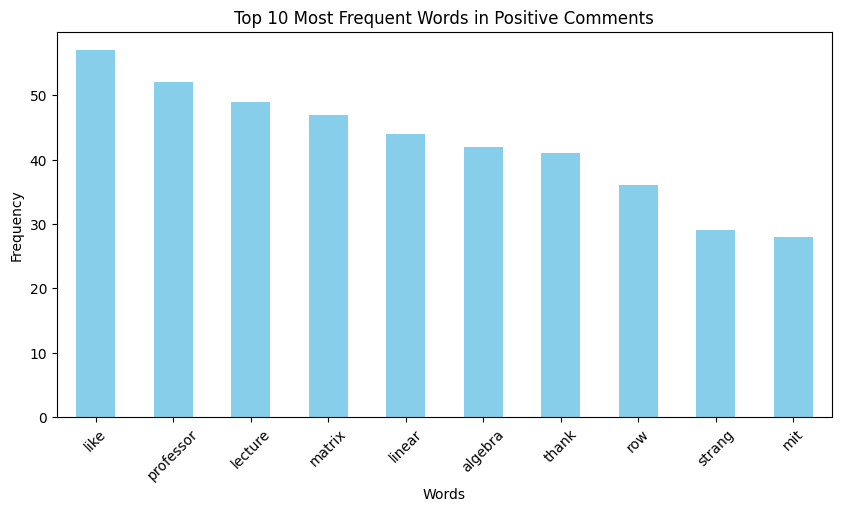

In [160]:
analyze_word_frequency(positive_comments, "Positive Comments")


Most Frequent Words in Negative Comments:
row            13
matrix         13
lecture        10
elimination    10
got            10
teacher         9
died            9
earlier         9
wrong           8
like            8
dtype: int64


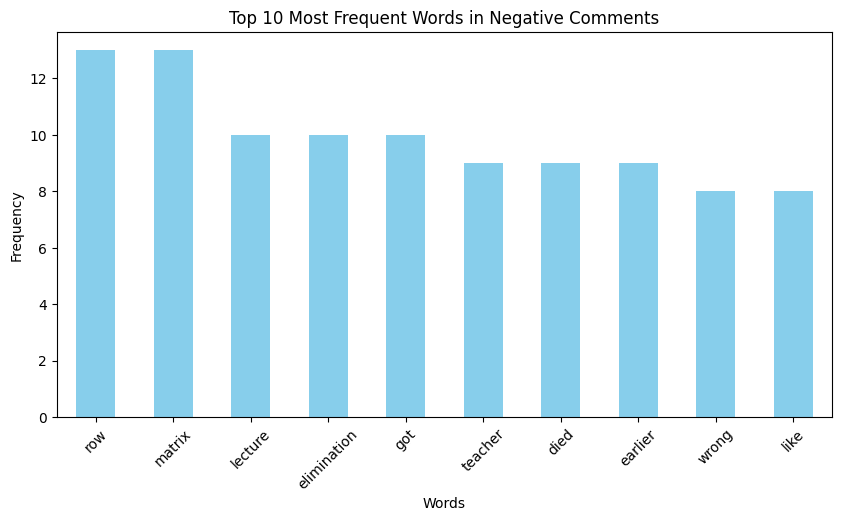

In [163]:

analyze_word_frequency(negative_comments, "Negative Comments")


Most Frequent Words in Neutral Comments:
row        717
matrix     621
lecture    426
linear     384
algebra    241
strang     236
right      235
know       213
guy        182
left       161
dtype: int64


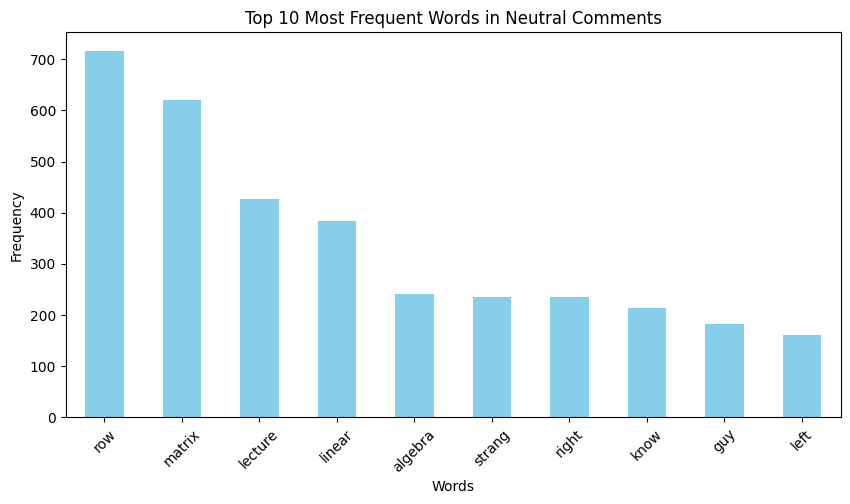

In [76]:
analyze_word_frequency(neutral_comments, "Neutral Comments")

**Q5)Summarization**

In [109]:
from transformers import pipeline

In [110]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [111]:
summarizer = pipeline("summarization", model="facebook/bart-large-cnn", device=0 if torch.cuda.is_available() else -1)

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [174]:
def chunk_text(text, max_chunk_size=6000):
    return [text[i:i + max_chunk_size] for i in range(0, len(text), max_chunk_size)]

def summarize_chunks(text_chunks):
    summarized_chunks = []


    for chunk in text_chunks:
        summary = summarizer(chunk, max_length=200, min_length=30, do_sample=False)[0]['summary_text']
        summarized_chunks.append(summary)
    return " ".join(summarized_chunks)

def summarize_long_text(text):
    if len(text) <= 6000:
        return summarizer(text, max_length=200, min_length=30, do_sample=False)[0]['summary_text']
    text_chunks = chunk_text(text)
    final_summary = summarize_long_text(text_chunks)
    return final_summary

In [175]:
def summarize_positive_comments(df):
    positive_comments = df[df['Basic Sentiment'] == "Positive"]['preprocessed_comment'].tolist()
    if not positive_comments:
        return "No positive comments available for summarization."

    positive_text = " ".join(positive_comments)
    return summarize_long_text(positive_text)


In [176]:
def summarize_negative_comments(df):
    negative_comments = df[df['Basic Sentiment'] == "Negative"]['preprocessed_comment'].tolist()
    if not negative_comments:
        return "No negative comments available for summarization."

    negative_text = " ".join(negative_comments)
    return summarize_long_text(negative_text)

In [177]:
def summarize_overall_comments(df):
    all_comments = df['preprocessed_comment'].tolist()
    overall_summary_text = summarize_long_text(" ".join(all_comments))

    total_comments = len(df)
    positive_count = len(df[df['basic_sentiment'] == 'Positive'])
    negative_count = len(df[df['basic_sentiment'] == 'Negative'])

    positive_percentage = (positive_count / total_comments) * 100
    negative_percentage = (negative_count / total_comments) * 100
    neutral_percentage = 100 - (positive_percentage + negative_percentage)

    majority_sentiment = "Positive" if positive_count > negative_count else "Negative"

    overall_summary = {
        'majority_sentiment': majority_sentiment,
        'common_themes': {
            'positive': positive_percentage,
            'negative': negative_percentage,
            'neutral': neutral_percentage
        },
        'overall_summary_text': overall_summary_text
    }
    return overall_summary

In [3]:
positive_summary = summarize_positive_comments(df)
positive_summary

'Every university linear algebra time begining everyone high school promise within month study engineering bit humbled introduction class man made lecture entertaining awesome wish knew lecture earlier professor like wanted learn math unlike classes meant eliminate many students going forward possible excellent lecture excellent instructor excellent courses comfort home.'

In [ ]:
negative_summary = summarize_negative_comments(df)
negative_summary

'Teachers college knew lectures would used learn lecture instead useless professors could hardly understand hey closed caption disappear word showed continue appear next word change audio video not sync either many empty chairs would die opportunity listen video live got bit confused not understand point made maybe leave author prove author textbook using though hah lecture video timeline links lecture elimination pivots. way teaching linear algebra taking example solving linear equations not throwing formulas without incentive really great dumb mit lectures much simpler easy understand professor sjsu conundrum.'

In [ ]:
overall_summary = summarize_overall_comments(df)
overall_summary

'{'majority_sentiment': 'Positive',
 'common_themes': {'positive': 55.294117647058826,
  'negative': 15.0,
  'neutral': 29.705882352941174},
 'overall_summary_text': 'Every university linear algebra time begining everyone high school promise within month study engineering bit humbled introduction class man made lecture entertaining awesome wish knew lecture earlier professor like wanted learn math unlike classes meant eliminate many students going forward possible note row abc matrix abc represent elimination matrices conundrum.'}'

**Q6)vizualization**

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

**Sentiment distribution(Positive/Negative/Neutral)**

In [166]:
sentiment_counts = df['Basic Sentiment'].value_counts()

<ipython-input-180-572ed898b2b9>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warnin

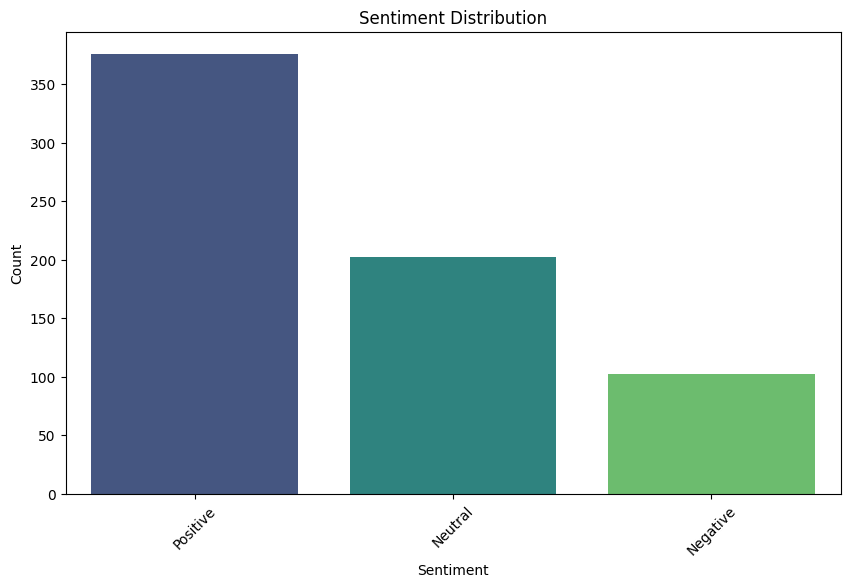

In [180]:
plt.figure(figsize=(10, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()



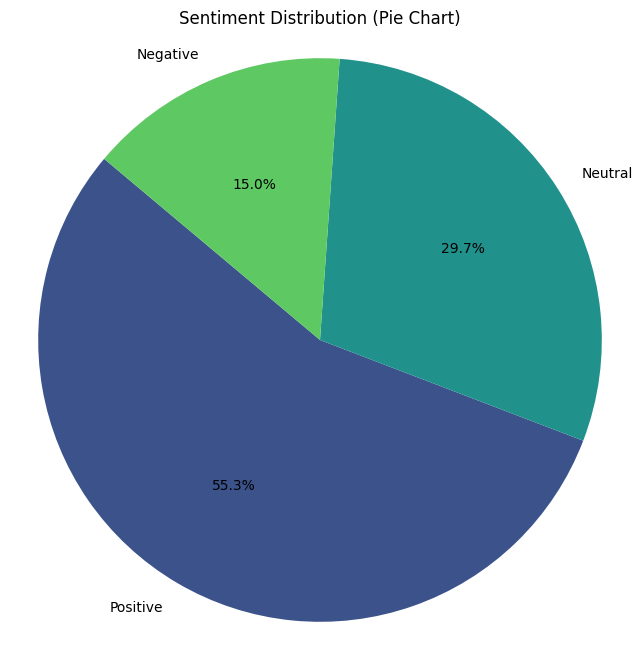

In [179]:
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', n_colors=len(sentiment_counts)))
plt.title('Sentiment Distribution (Pie Chart)')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is a circle.
plt.show()

**comparing the no. of strong vs Genral Sentiments**

<ipython-input-168-3a30ee30a447>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentiment Category'] = df['Fine-Grained Sentiment'].apply(classify_sentiment)
<ipython-input-168-3a30ee30a447>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_comparison.index, y=sentiment_comparison.values, palette='coolwarm')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = gr

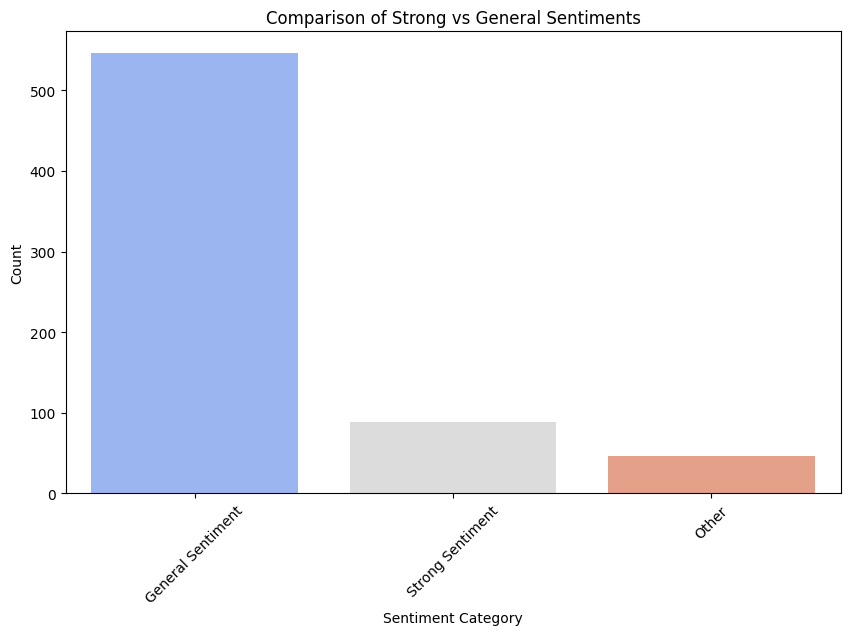

In [168]:
def classify_sentiment(sentiment):
    if sentiment in ['Strong Positive', 'Strong Negative']:
        return 'Strong Sentiment'
    elif sentiment in ['General Positive', 'General Negative', 'Neutral']:
        return 'General Sentiment'
    return 'Other'

# Apply the classification
df['Sentiment Category'] = df['Fine-Grained Sentiment'].apply(classify_sentiment)

# Count the occurrences of each category
sentiment_comparison = df['Sentiment Category'].value_counts()

# Plotting the comparison
plt.figure(figsize=(10, 6))
sns.barplot(x=sentiment_comparison.index, y=sentiment_comparison.values, palette='coolwarm')
plt.title('Comparison of Strong vs General Sentiments')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

**Words clouds for Positive/Negative/Neutral**

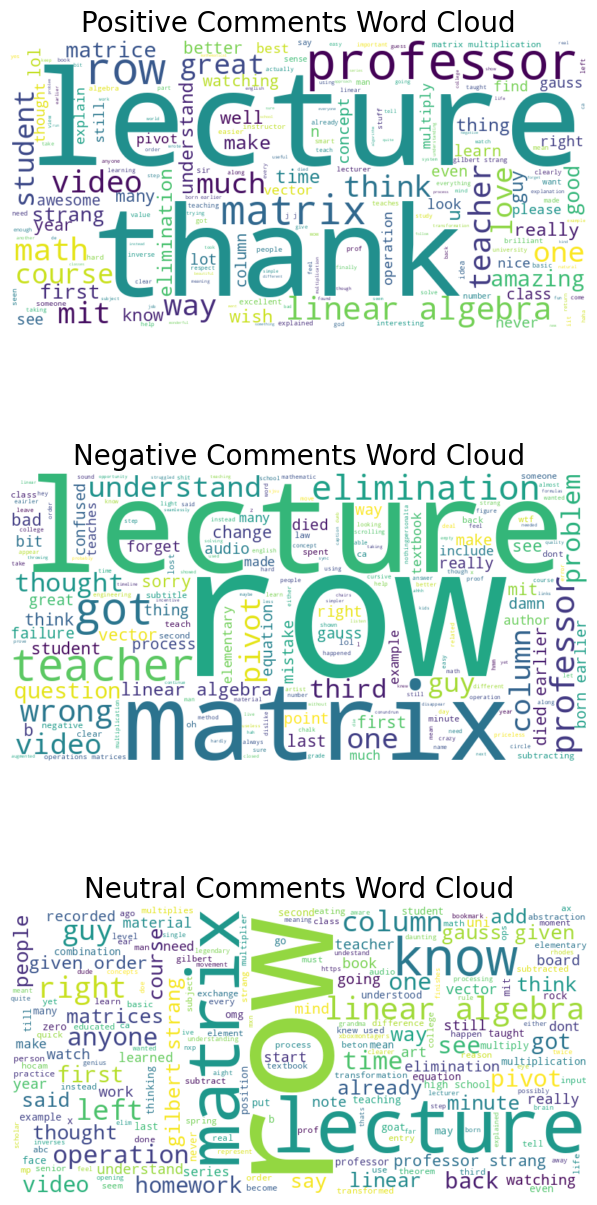

In [181]:
def generate_wordcloud(data, ax, title):
    text = ' '.join(data)  # Join all the comments into a single string
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')  # Hide the axis
    ax.set_title(title, fontsize=20)

# Create a figure with subplots for each sentiment category
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Generate word clouds for each sentiment category
positive_comments = df[df['Basic Sentiment'] == 'Positive']['preprocessed_comment']
negative_comments = df[df['Basic Sentiment'] == 'Negative']['preprocessed_comment']
neutral_comments = df[df['Basic Sentiment'] == 'Neutral']['preprocessed_comment']

# Create word clouds in the respective subplots
generate_wordcloud(positive_comments, axes[0], 'Positive Comments Word Cloud')
generate_wordcloud(negative_comments, axes[1], 'Negative Comments Word Cloud')
generate_wordcloud(neutral_comments, axes[2], 'Neutral Comments Word Cloud')

# Adjust space between subplots
plt.subplots_adjust(hspace=0.5)  # Increase this value to create more space

# Show the plots
plt.show()

**Clustering reviews with color coding**

In [130]:

!pip install sentence_transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 4.5 MB/s eta 0:00:00


In [131]:
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import torch

In [132]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = SentenceTransformer('paraphrase-MiniLM-L6-v2').to(device)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [170]:
comments = df['preprocessed_comment'].tolist()

embeddings = model.encode(comments, show_progress_bar=True, convert_to_tensor=True).to(device)

embeddings = embeddings.cpu().numpy()

Batches:   0%|          | 0/22 [00:00<?, ?it/s]

In [172]:
from sklearn.cluster import KMeans
tsne = TSNE(n_components=3, random_state=42)
tsne_results = tsne.fit_transform(embeddings)

df['tsne_1'] = tsne_results[:, 0]
df['tsne_2'] = tsne_results[:, 1]
df['tsne_3'] = tsne_results[:, 2]
kmeans = KMeans(n_clusters=3, random_state=28)
df['cluster'] = kmeans.fit_predict(tsne_results)

<ipython-input-172-93712f35bf81>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = kmeans.fit_predict(tsne_results)


In [173]:
import plotly.express as px

fig = px.scatter_3d(
    df, x='tsne_1', y='tsne_2', z='tsne_3', color='cluster',
    hover_data={'preprocessed_comment': True, 'tsne_1': False, 'tsne_2': False, 'tsne_3': False},
    title="3D t-SNE Clustering of Comments Based on Sentiment"
)

fig.update_layout(
    scene = dict(
        xaxis_title="t-SNE Dimension 1",
        yaxis_title="t-SNE Dimension 2",
        zaxis_title="t-SNE Dimension 3"
    ),
    legend_title="Cluster"
)


fig.show()